# 필요한 모듈 임포트

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# 학습, 벨리데이션 경로 및 라벨 설정

In [ ]:
dataset_dir = '/content/drive/MyDrive/ImageFolder'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = os.listdir('/content/drive/MyDrive/ImageFolder/train')
val_dir = os.listdir('/content/drive/MyDrive/ImageFolder/validation')

In [ ]:
# GPU사용 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 이미지 증강 기법

In [ ]:
# 이미지 증강 기법
# data_trainsforms
data_trainsforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

# 데이터셋 객체 생성

In [ ]:
# 데이터셋 객체 생성
image_datasets = {
    'train': datasets.ImageFolder('/content/drive/MyDrive/ImageFolder/train', data_trainsforms['train']),
    'validation': datasets.ImageFolder('/content/drive/MyDrive/ImageFolder/validation', data_trainsforms['validation'])
}

# 데이터 로더 생성

In [ ]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=16,
        shuffle=True
    )
    ,
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=16,
        shuffle=False
    )
}

In [ ]:
print(len(image_datasets['train']))
print(len(image_datasets['validation']))

3229
1397


'11'

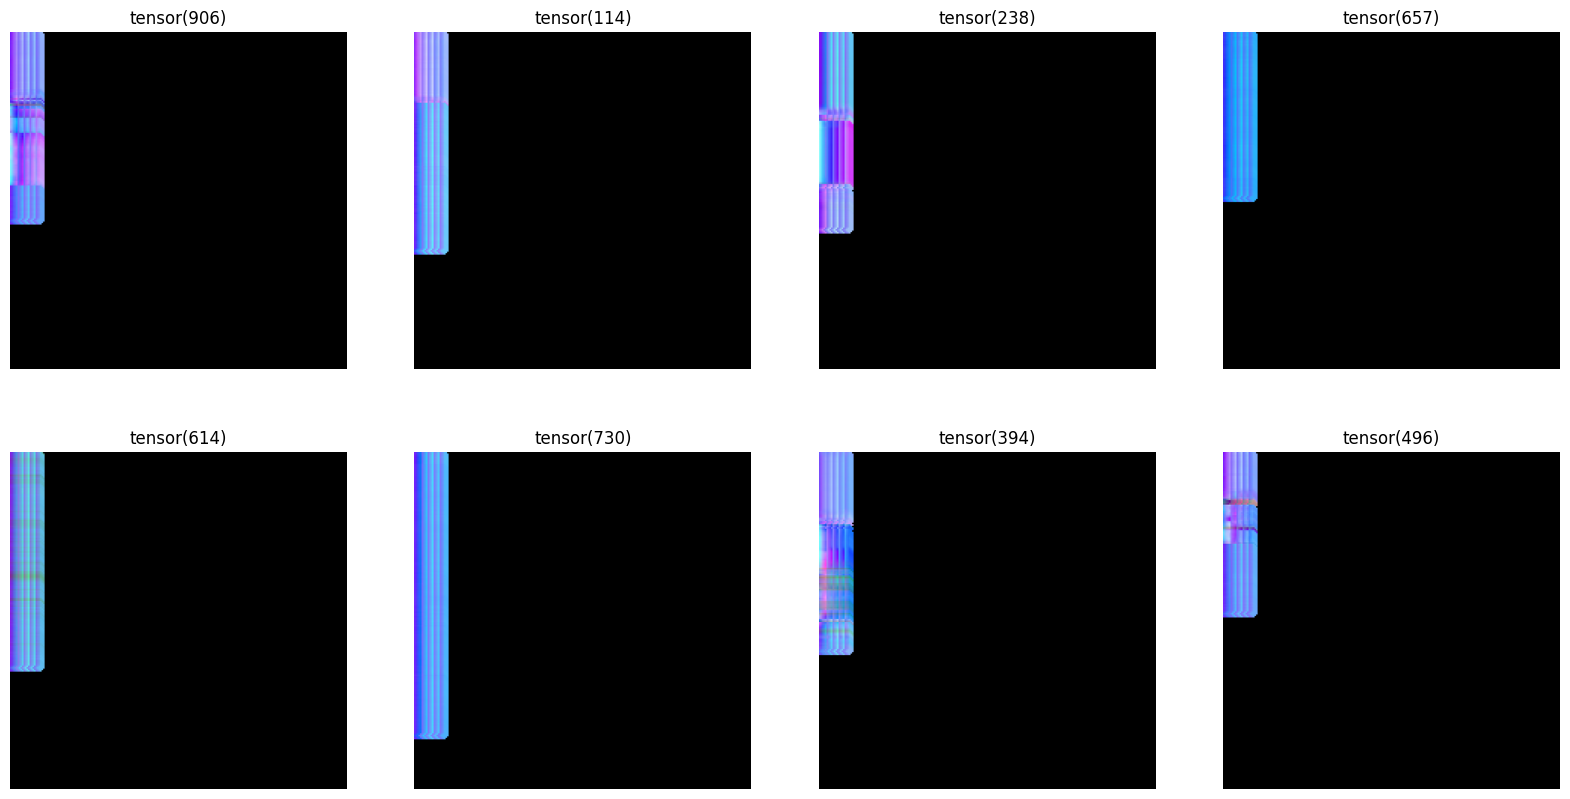

In [ ]:
# train 데이터 로더 확인
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(2, 4, figsize=(20,10))

for img, label,ax in zip(imgs, labels, axes.flatten()):
    ax.imshow(img.permute(1,2,0))
    ax.set_title(label)
    ax.axis('off')

image_datasets['train'].classes[11]

In [ ]:
class ResNetCustom(nn.Module):
    def __init__(self, num_classes=982):
        super(ResNetCustom, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.resnet.fc(x)

        return x

# 모델 생성
model = ResNetCustom().to(device)

# 모델 출력
print(model)

ResNetCustom(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/ossProject/모델/예린/모델_다운/model_test.pth')
model.load_state_dict(checkpoint)
model.train()

ResNetCustom(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:
epochs = 10
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)

for epoch in range(epochs + 1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch).to(device)
            loss = nn.CrossEntropyLoss()(y_pred,  y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses += loss.item()  # loss.item()을 사용하여 loss 값을 가져옵니다.
            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)

            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
            sum_accs += acc.item()  # acc.item()을 사용하여 acc 값을 가져옵니다.

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss: 3.6752 Accuracy: 35.56%
validation: Epoch    1/10 Loss: 6.3999 Accuracy: 9.18%
train     : Epoch    2/10 Loss: 2.5697 Accuracy: 42.56%
validation: Epoch    2/10 Loss: 6.8226 Accuracy: 8.74%
train     : Epoch    3/10 Loss: 2.3052 Accuracy: 49.23%
validation: Epoch    3/10 Loss: 6.5972 Accuracy: 9.89%
train     : Epoch    4/10 Loss: 2.0708 Accuracy: 52.96%
validation: Epoch    4/10 Loss: 6.8327 Accuracy: 10.95%
train     : Epoch    5/10 Loss: 1.8274 Accuracy: 58.78%
validation: Epoch    5/10 Loss: 6.8072 Accuracy: 11.66%
train     : Epoch    6/10 Loss: 1.6785 Accuracy: 61.72%
validation: Epoch    6/10 Loss: 6.9127 Accuracy: 10.80%
train     : Epoch    7/10 Loss: 1.5069 Accuracy: 66.03%
validation: Epoch    7/10 Loss: 6.9484 Accuracy: 12.02%
train     : Epoch    8/10 Loss: 1.3686 Accuracy: 69.09%
validation: Epoch    8/10 Loss: 6.9816 Accuracy: 12.03%
train     : Epoch    9/10 Loss: 1.2298 Accuracy: 71.98%
validation: Epoch    9/10 Loss: 6.9236 Accuracy: 12

In [ ]:
# 학습된 모델 파일  저장
torch.save(model.state_dict(),'/content/drive/MyDrive/ossProject/모델/예린/모델_다운/model_test.pth')